In [257]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [258]:
import sys
sys.path.append('/tank/klundert/projects/cfdn/prfpy_cfdn/')
import os
import numpy as np
import preprocess
import glob
import natsort
import cortex as cx
import numpy as np
import scipy as sp
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request
import cortex as cx
from matplotlib import rc
import nibabel as nb
from nibabel import cifti2
import h5py
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel, Norm_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter, Norm_Iso2DGaussianFitter
from prfpy.utils import Subsurface
from prfpy.stimulus import CFStimulus
from prfpy.model import CFGaussianModel
from prfpy.fit import CFFitter
from prfpy.model import Norm_CFGaussianModel
from prfpy.fit import Norm_CFGaussianFitter
from scipy.optimize import LinearConstraint, NonlinearConstraint
from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation
from preprocess import get_cortex
# import cfhcpy
# from cfhcpy.base import AnalysisBase
import pandas as pd
import h5py
from scipy.stats import sem
from scipy.stats import f_oneway
# import scikit_posthocs as sp
from copy import deepcopy

In [449]:
## data average all folds/subs for each model plus add the average x and y values

### non-WEIGHTED

all_data_gauss = []
all_data_DN = []


for i, sub in enumerate([2]):
    print(sub)
    
    
    for model in ['gauss_prf', 'DN_prf']:
        both_folds = []
        # print(model)
        for folds in [0]:

            for j, infile in enumerate(natsort.natsorted((glob.glob(f'/tank/klundert/fsnative_folds_prf/fsnative_data2/{model}_sub-{sub}_fold-{folds}_slice-*.npy')))):
                # print(j)
                if j == 0:
                    dattest = np.load(infile)
                else:
                    dattest = np.vstack([dattest, np.load(infile)])

                
            both_folds.append(dattest)
        if model == 'gauss_prf':
            all_data_gauss.append(np.mean(both_folds, axis=0))
            
        if model == 'DN_prf':
            all_data_DN.append(np.mean(both_folds, axis=0))
            
prf_gauss = all_data_gauss[0] 
prf_dn = np.copy(all_data_DN[0])
prf_dn.shape

# prf_dn2[vox,:]

2


(277492, 12)

In [197]:
np.load('/tank/klundert/fsnative_folds_prf/fsnative_data2/DN_prf_sub-2_vox-4050.npy')

array([[-8.72752964e-01, -1.24784318e+01,  1.45652284e-01,
         3.22145702e-01,  5.13879435e-16,  1.16970905e+01,
         7.93715812e+00,  7.28114736e-06,  4.87756469e+01,
         2.17784594e+00,  6.05549585e-17, -5.25242128e-01]])

In [184]:
np.where((prf_gauss[:,-1] - prf_dn[:,-1]) > 0.1)[0][:15]

array([273, 274, 281, 393, 404, 435, 444, 452, 460, 514, 575, 576, 600,
       643, 645])

In [382]:
# np.where((prf_gauss[:,-1] - prf_dn[:,-1]) > 0.1)[0][:15]
refit_mask = ((prf_gauss[:,-1] - prf_dn[:,-1]) > 0.1)

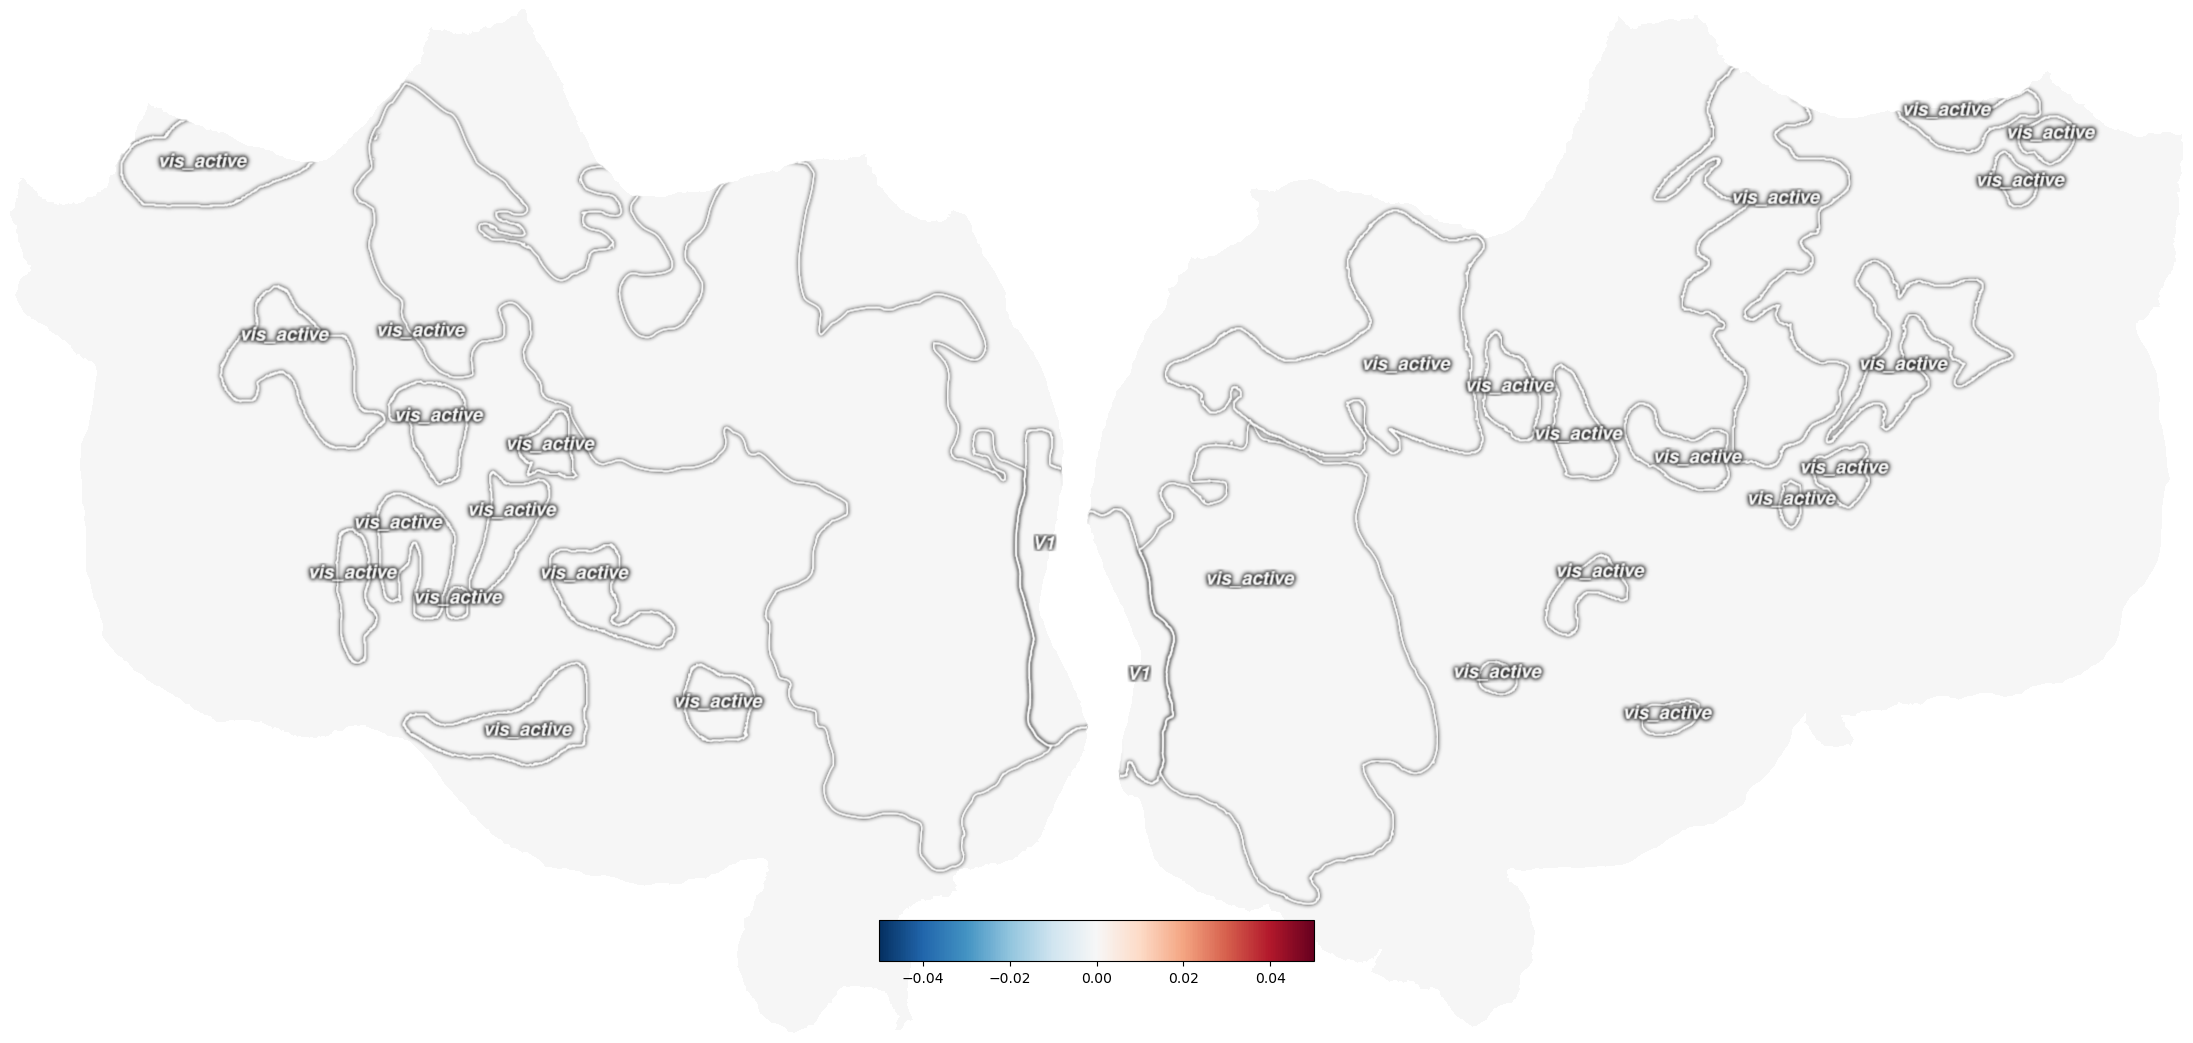

In [479]:
# toplot = np.zeros([boolmask.shape[0],])
# toplot[:] = np.nan
# toplot = ecc(prf_dn[:,1], prf_dn[:,0]*-1)
toplot = prf_dn[:,-1] * 0
toplot[refit_mask] = gf_norm.iterative_search_params[:,-1] - prf_dn[:,-1][refit_mask]
cx.quickshow(cx.Vertex(toplot, 'sub-02', vmin=-0.05, vmax=0.05), with_curvature=True);

In [462]:
refit_mask = ((prf_gauss[:,-1] - prf_dn[:,-1]) > 0.1)* (prf_dn_grid[:,-1] > 0.5)

refit_mask.sum()

378

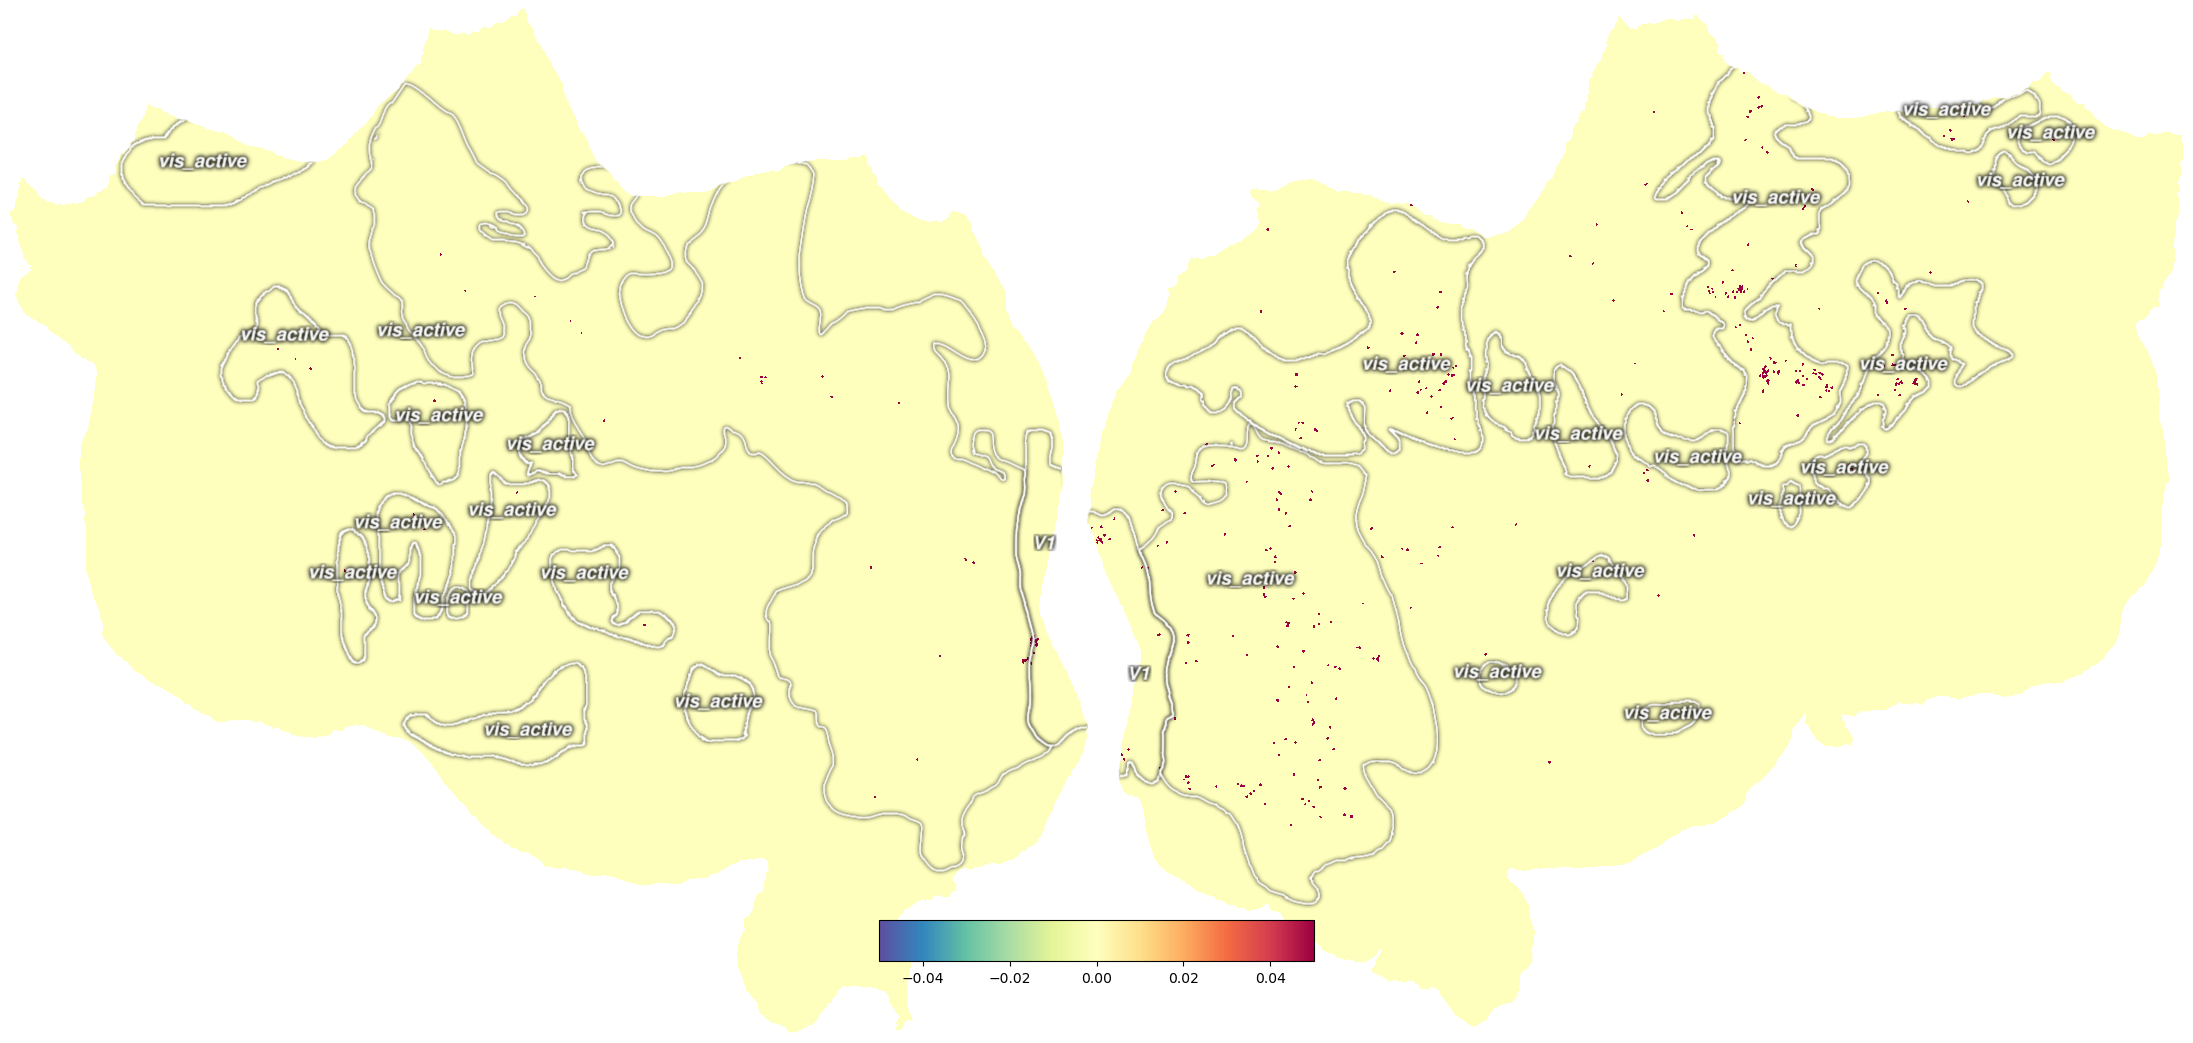

In [458]:
toplot = ((prf_gauss[:,-1] - prf_dn[:,-1]) > 0.1)* (prf_dn_grid[:,-1] > 0.5)


cx.quickshow(cx.Vertex(toplot, subject='sub-02', cmap='spectral_r', vmin=-0.05, vmax=0.05), with_curvature=True);
# plt.title('dn cort - gauss cort')

In [389]:
## data average all folds/subs for each model plus add the average x and y values

### non-WEIGHTED

all_data_gauss = []
all_data_DN = []


for i, sub in enumerate([2]):
    print(sub)
    
    
    for model in ['gauss_prf', 'norm_grid']:
        both_folds = []
        # print(model)
        for folds in [0]:

            for j, infile in enumerate(natsort.natsorted((glob.glob(f'/tank/klundert/fsnative_folds_prf/fsnative_data2/{model}_sub-{sub}_fold-{folds}_slice-*.npy')))):
                # print(j)
                if j == 0:
                    dattest = np.load(infile)
                else:
                    dattest = np.vstack([dattest, np.load(infile)])

                
            both_folds.append(dattest)
        if model == 'gauss_prf':
            all_data_gauss.append(np.mean(both_folds, axis=0))
            
        if model == 'norm_grid':
            all_data_DN.append(np.mean(both_folds, axis=0))
            
prf_gauss = all_data_gauss[0] 
prf_dn_grid = all_data_DN[0]
prf_dn.shape

2


(277492, 12)

In [263]:
from prfpy.model import Norm_Iso2DGaussianModel

s2_f = get_cortex(np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold2_sub-02_psc.npy'))
new_dms = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/prf_dm.npy')[5:,:,:]

prf_stim = PRFStimulus2D(screen_size_cm=69, 
                         screen_distance_cm=220, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

# to set up parameter bounds in iterfit
inf = np.inf
eps = 1e-1
ss = prf_stim.screen_size_degrees

gg = Iso2DGaussianModel(stimulus=prf_stim,
                        filter_predictions=False,
                        filter_type='dc')


gg_norm = Norm_Iso2DGaussianModel(stimulus=prf_stim,
                                    filter_predictions=False,
                                    filter_type='dc',
                                    )

In [175]:
toplot = prf_gauss[:,-1]
toplot.shape
# cx.quickshow(cx.Vertex(toplot, subject='sub-02_test', cmap='spectral_r', vmin=0, vmax=1), with_curvature=True);


(277492,)

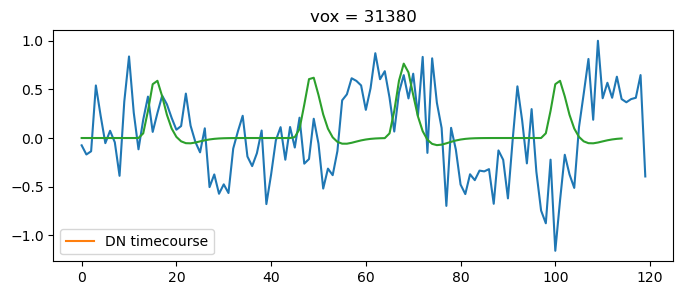

In [268]:
for vox in np.where((prf_gauss[:,-1] - prf_dn[:,-1]) > 0.1)[0][2020:2021]:
    plt.figure(figsize=[8,3])

    plt.plot(s2_f[vox,:])

    plt.plot(gg_norm.return_prediction(*prf_dn[vox,:-1].T).T, label = f'DN timecourse')
    plt.plot(gg.return_prediction(*prf_gauss[vox,:-1].T).T)
    plt.legend()
    plt.title(f'vox = {vox}')
    # s2_f[45202,:]

#     print(prf_dn[vox,:])
#     print(prf_gauss[vox,:])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 1.13702097e+01  4.39478665e+00  1.07946503e-01 -7.05846480e+00
 -1.94262540e-18  1.33575933e+01  1.05257557e+01  1.40933831e-06
  1.07866382e+01  9.34959948e-01 -2.77821918e-33  8.63970893e-01]


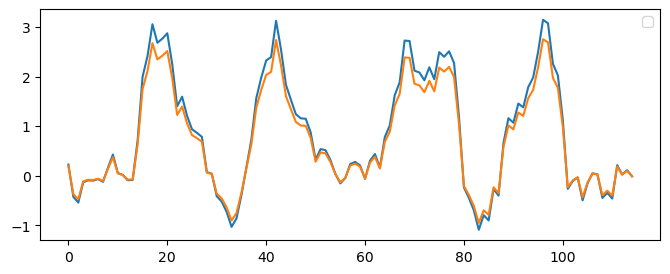

In [463]:
s2_f = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_detrend_sub-02_psc_fsnative.npy')


# vox = 26341
# vox = 137052
# vox = 20202
vox = 275820
plt.figure(figsize=[8,3])

plt.plot(s2_f[vox,:])

plt.plot(gg_norm.return_prediction(*prf_dn[vox,:-1].T).T, label = f'DN timecourse')
plt.plot(gg_norm.return_prediction(*prf_dn_grid[vox,:-1].T).T, label = f'DN grid timecourse')

# plt.plot(gg.return_prediction(*prf_gauss[vox,:-1].T).T)
plt.legend()
# s2_f[45202,:]

print(prf_dn[vox,:])
# print(prf_dn_grid[vox,:])
# print(prf_gauss[vox,:])


# norm_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
#                 (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
#                 (eps, 1.5*ss),  # prf size
#                 (-1000, 1000),  # prf amplitude
#                 (0, 0),  # bold baseline
#                 (0, 1000),  # surround amplitude
#                 (eps, 3*ss),  # surround size
#                 (0, 1000),  # neural baseline  7 B
#                 (1e-6, 1000)]  # surround baseline 8 D


In [464]:
fold = 0

sub=2
########################################################################################
# set parameters
########################################################################################


fit_hrf = True
constraints_gauss, constraints_css, constraints_dog, constraints_norm = [],[],[],[]


new_dms = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/prf_dm.npy')[5:,:,:]

prf_stim = PRFStimulus2D(screen_size_cm=69, 
                         screen_distance_cm=220, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

# to set up parameter bounds in iterfit
inf = np.inf
eps = 1e-1
ss = prf_stim.screen_size_degrees




if fold == 0:
    mydat_train_stim = np.nan_to_num(np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_detrend_sub-0{sub}_psc_fsnative.npy'))
    mydat_test_stim = np.nan_to_num(np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold2_detrend_sub-0{sub}_psc_fsnative.npy'))
else:
    mydat_train_stim = np.nan_to_num(np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold2_detrend_sub-0{sub}_psc_fsnative.npy'))
    mydat_test_stim = np.nan_to_num(np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_detrend_sub-0{sub}_psc_fsnative.npy'))









In [331]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

cf


In [ ]:
# self.gridsearch_params[self.gridsearch_rsq_mask] = np.array([
#     self.gaussian_params[self.gridsearch_rsq_mask, 0],
#     self.gaussian_params[self.gridsearch_rsq_mask, 1],
#     self.gaussian_params[self.gridsearch_rsq_mask, 2],
#     self.best_fitting_beta,
#     self.best_fitting_baseline,
#     self.sa[max_rsqs],
#     self.ss[max_rsqs],
#     self.nb[max_rsqs] * self.best_fitting_beta,
#     self.sb[max_rsqs],
#     self.gridsearch_r2
# ]).T

# # output
# self.gridsearch_params = np.array([
#     self.model.xs.ravel()[max_rsqs],
#     self.model.ys.ravel()[max_rsqs],
#     self.model.sizes.ravel()[max_rsqs],
#     self.best_fitting_beta,
#     self.best_fitting_baseline,
#     self.gridsearch_r2
# ]).T


In [469]:
refit_mask.sum()

378

In [468]:
# fitsize = np.ceil(len(mydat_train_stim)/350).astype(int)
# print(f'fitsize is {fitsize}')

n_jobs = 25

# vox=20202
# vox = 26341
# vox = 275820




# mydat_train = mydat_train_stim[vox,:][np.newaxis]
# mydat_test = mydat_test_stim[vox,:][np.newaxis]

mydat_train = mydat_train_stim[refit_mask,:]
mydat_test = mydat_test_stim[refit_mask,:]

# mydat_test = split_given_size(mydat_test_stim, 3294)[slice_n]

#model=CFGaussianModel(train_stim)

# Define grid of parameters to search over
surround_amplitude_grid=np.array([0.05,0.2,0.4,0.7,1,3], dtype='float32')
surround_size_grid=np.array([3,5,8,12,18], dtype='float32')
neural_baseline_grid=np.array([0,1,10,50,100], dtype='float32')
surround_baseline_grid=np.array([0.1,1.0,10.0,100.0], dtype='float32')

gauss_grid_bounds = [(0,1000)] #only prf amplitudes between 0 and 1000
norm_grid_bounds = [(0,1000),(0,1000)] #only prf amplitudes between 0 and 1000, only neural baseline values between 0 and 1000


# surround_amplitude_grid=np.array([0.05,0.2,0.4,0.7,1,3], dtype='float32')
# surround_size_grid=np.array([3,5,8,12,18], dtype='float32')
# neural_baseline_grid=np.array([0,1,10,50,100,170], dtype='float32')
# surround_baseline_grid=np.array([0.1,1.0,5.0,10.0,50.0,100.0,170.0], dtype='float32')

# define the bounds of the grid
gauss_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
                (eps, 1.5*ss),  # prf size
                (-1000, 1000),  # prf amplitude
                (0, 0)]  # bold baseline



norm_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
                (eps, 1.5*ss),  # prf size
                (-1000, 1000),  # prf amplitude
                (0, 0),  # bold baseline
                (0, 1000),  # surround amplitude
                (eps, 3*ss),  # surround size
                (0, 1000),  # neural baseline  7 B
                (1e-6, 1000)]  # surround baseline 8 D

if fit_hrf:
    norm_bounds += [(0,10),(0,0)]
    gauss_bounds += [(0,10),(0,0)]


# Define the model and fitter etc
gg = Iso2DGaussianModel(stimulus=prf_stim,
                        filter_predictions=False,
                        filter_type='dc')

gf_P = Iso2DGaussianFitter(data=mydat_train, model=gg, n_jobs=n_jobs, fit_hrf=fit_hrf)
gf_P.grid_fit(ecc_grid=eccs,
                 polar_grid=polars,
                 size_grid=sizes, 
                 n_batches=60,
                 fixed_grid_baseline=0,
                 grid_bounds=gauss_grid_bounds)



gf_P.iterative_fit(rsq_threshold=-1, verbose=True, bounds=gauss_bounds, constraints=[], xtol=1e-5, ftol=1e-5)

gf_P.crossvalidate_fit(mydat_test, single_hrf=True)





Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 91, function evaluations: 744, CG iterations: 177, optimality: 1.21e-02, constraint violation: 0.00e+00, execution time:  4.3 s.


[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/downloads/cfpy/prfpy/model.py:336: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf =

In [ ]:
s2_f.shape

array([ 5.59694887e-01, -1.40893181e-01,  1.00924088e-01,  1.60349579e+02,
        0.00000000e+00,  5.00000007e-02,  8.00000000e+00,  1.60349579e+02,
        1.00000000e+02,  1.55159622e-01])

In [ ]:
# oldgrid = np.array([[   0.59886122,   -2.55323674,    3.63655848,   -1.75216877,
#            0.        ,    0.69999999,    3.        , -297.86868286,
#           50.        ,    0.84870511]])


# array([[ 0.59886122, -2.55323674,  3.63655848, -0.09708601,
#         0.        , 0.05      ,  3.        , -4.8543005 ,  1.        ,  0.84177089]])

array([[ 0.59886122, -2.55323674,  3.63655848, -0.09708601,  0.        ,
         0.05      ,  3.        , -4.8543005 ,  1.        ,  0.84177089]])

In [470]:
############################
# ftting norm model
############################

n_jobs = 30

# Define the model and fitter etc
gg_norm = Norm_Iso2DGaussianModel(stimulus=prf_stim,
                                    filter_predictions=False,
                                    filter_type='dc',
                                    )

gf_norm = Norm_Iso2DGaussianFitter(data=mydat_train,
                                   model=gg_norm,
                                   n_jobs=n_jobs,
                                   fit_hrf=fit_hrf,
                                   previous_gaussian_fitter=gf_P)


surround_amplitude_grid=np.array([0.05,0.2,0.4,0.7,1,3], dtype='float32')
surround_size_grid=np.array([3,5,8,12,18], dtype='float32')
neural_baseline_grid=np.array([0,1,10,50,100], dtype='float32')
surround_baseline_grid=np.array([0.1,1.0,10.0,100.0], dtype='float32')





gf_norm.grid_fit(surround_amplitude_grid,
             surround_size_grid,
             neural_baseline_grid,
             surround_baseline_grid,
             verbose=False,
             n_batches=60,
             rsq_threshold=0.01,
             fixed_grid_baseline=0,
             grid_bounds=norm_grid_bounds)


# print(np.round(gf_norm.gridsearch_params, 5))


if fit_hrf:
    A_ssc_norm = np.array([[0,0,-1,0,0,0,1,0,0,0,0]])
else:
    A_ssc_norm = np.array([[0,0,-1,0,0,0,1,0,0]])

constraints_norm.append(LinearConstraint(A_ssc_norm,
                                            lb=0,
                                            ub=+inf))


constraints_norm.append(LinearConstraint(A_ssc_norm, lb=0, ub=+inf))


gf_norm.iterative_fit(rsq_threshold=0.01, verbose=False, bounds=norm_bounds, constraints=constraints_norm, xtol=1e-7, ftol=1e-7)

gf_norm.crossvalidate_fit(mydat_test, single_hrf=True)

Performing bounded, constrained minimization (trust-constr).
`gtol` termination condition is satisfied.
Number of iterations: 73, function evaluations: 552, CG iterations: 206, optimality: 5.72e-06, constraint violation: 0.00e+00, execution time:  8.2 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 103, function evaluations: 760, CG iterations: 238, optimality: 7.88e-02, constraint violation: 0.00e+00, execution time: 1.1e+01 s.
Performing bounded, constrained minimization (trust-constr).
`xtol` termination condition is satisfied.
Number of iterations: 99, function evaluations: 840, CG iterations: 184, optimality: 1.76e-01, constraint violation: 0.00e+00, execution time: 1.2e+01 s.
Performing bounded, constrained minimization (trust-constr).
`gtol` termination condition is satisfied.
Number of iterations: 452, function evaluations: 3816, CG iterations: 1634, optimality: 3.82e-06, constraint violation: 0.00

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/downloads/cfpy/prfpy/model.py:566: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf == 'direct':
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is expe

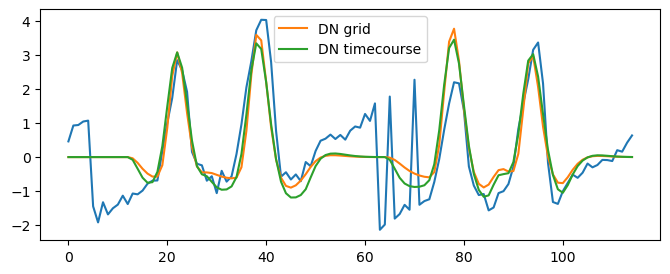

In [473]:
plt.figure(figsize=[8,3])

plt.plot(mydat_train[0,:])

# plt.plot(gg.return_prediction(*gf_P.iterative_search_params[0,:-1].T).T, label = 'gauss')
plt.plot(gg_norm.return_prediction(*gf_norm.gridsearch_params[0,:-1].T).T, label = f'DN grid')

plt.plot(gg_norm.return_prediction(*gf_norm.iterative_search_params[0,:-1].T).T, label = f'DN timecourse')
# plt.plot(gg_norm.return_prediction(*oldgrid[0,:-1].T).T, label = f'DN oldgrid')


# plt.plot(gg_norm.return_prediction(*gf_norm.gridsearch_params[0,:-1].T).T, label = f'DN timecourse')

# plt.plot(gg.return_prediction(*gf_P.iterative_search_params[0,:-1].T).T)
# plt.plot(gg.return_prediction(*prf_gauss[vox,:-1].T).T)
plt.legend()
# plt.title(f'{gf_norm.gridsearch_params}')


In [397]:
gf_norm.iterative_search_params

array([[-1.46283333e+00,  3.54541858e+00,  2.93854671e+00,
         4.91710899e+00, -3.11006478e-16,  3.37722583e-01,
         3.02362634e+00,  8.04660022e+00,  6.72459255e-01,
         1.64951980e+00, -5.90283332e-18,  8.63931556e-01]])

In [393]:
print(np.round(gf_norm.iterative_search_params, 2)[0])
print(np.round(gf_norm.gridsearch_params, 2)[0])
print(np.round(prf_dn[vox,:], 2))
print(np.round(prf_dn_grid[vox,:], 2))
# plt.plot(gg.create_hrf([1, gf_norm.gridsearch_params[0,-2], gf_norm.gridsearch_params[0,-1]]).T)
# gf_norm.gridsearch_params[0,-1]

[-1.46  3.55  2.94  4.92 -0.    0.34  3.02  8.05  0.67  1.65 -0.    0.86]
[-2.07  3.54  4.38  0.84  0.    0.2   8.    0.84  1.    0.81]
[11.37  4.39  0.11 -7.06 -0.   13.36 10.53  0.   10.79  0.93 -0.   -0.51]
[ -2.07   3.54   4.38  -0.27   0.     0.7    3.   -27.4   10.     0.85]


In [136]:
norm_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x     0
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y    1
                (eps, 1.5*ss),  # prf size                     2
                (-1000, 1000),  # prf amplitude                3
                (0, 0),  # bold baseline                       4
                (0, 1000),  # surround amplitude               5
                (eps, 3*ss),  # surround size                  6
                (0, 1000),  # neural baseline  7 B             7
                (1e-6, 1000)]  # surround baseline 8 D         8


array([ 4.00713408, -3.45984411,  4.01884411,  0.00958183,  0.        ,
        1.        ,  0.        ,  0.78350491])

In [299]:
norm_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
                (eps, 1.5*ss),  # prf size
                (-1000, 1000),  # prf amplitude
                (0, 0),  # bold baseline
                (0, 1000),  # surround amplitude
                (eps, 3*ss),  # surround size
                (0, 1000),  # neural baseline  7 B
                (1e-6, 1000)]  # surround baseline 8 D

if fit_hrf:
    norm_bounds += [(0,10),(0,0)]
    gauss_bounds += [(0,10),(0,0)]
    
    
norm_bounds
np.round(gf_norm.iterative_search_params, 2)

array([[  3.83, -11.83,   0.49,  -5.72,  -0.  ,   9.02,   7.38,   0.  ,
         10.32,   2.78,  -0.  ,  -0.33]])